In [1]:
%matplotlib nbagg

In [2]:
import json

import matplotlib.pyplot as plt
import zmq
import lz4.block, lz4.frame
import numpy as np
from libertem.common.math import prod
import bitshuffle

In [ ]:
context = zmq.Context()
zmq_socket = context.socket(zmq.PULL)
HOST = '127.0.0.1'
zmq_socket.connect(f"tcp://{HOST}:9999")

In [ ]:
debugbuffer = []

In [ ]:
def recv(zmq_socket):
    res = 0
    while not res:
        res = zmq_socket.poll(100)
    return zmq_socket.recv()

def receive_acquisition_header(zmq_socket, acquisition_id):
    while True:
        data = recv(zmq_socket)
        try:
            header_header = json.loads(data)
        except (json.JSONDecodeError, UnicodeDecodeError):
            continue
        if 'header_detail' in header_header and header_header['series'] == acquisition_id:
            break
    header = json.loads(recv(zmq_socket))
    
    return header_header, header

def receive_frame(zmq_socket, frame_id, acquisition_id):
    header_header = json.loads(recv(zmq_socket))
    assert header_header['series'] == acquisition_id
    
    header = json.loads(recv(zmq_socket))
    shape = header['shape']
    # type and endianness
    dtype = np.dtype(header['type']).newbyteorder(header['encoding'][-1])
    size = prod(shape) * dtype.itemsize
    
    data = recv(zmq_socket)
    if header['encoding'] in ('bs32-lz4<', 'bs16-lz4<', 'bs8-lz4<'):
        decompressed = bitshuffle.decompress_lz4(
            np.frombuffer(data[12:], dtype=np.uint8),
            shape=shape,
            dtype=dtype,
            block_size=0
        )
    elif header['encoding'] == 'lz4<':
        decompressed = lz4.block.decompress(data, uncompressed_size=size)
        decompressed = np.frombuffer(decompressed, dtype=dtype).reshape(shape)
    elif header['encoding'] == '<':
        decompressed = np.frombuffer(data, dtype=dtype).reshape(shape)
    else:
        raise RuntimeError(f'Unsupported encoding {header["encoding"]}')
    
    footer = json.loads(recv(zmq_socket))
    return header_header, header, decompressed, footer

def receive_acquisition_footer(zmq_socket):
    footer = recv(zmq_socket)
    return footer

def receive_acquisition(zmq_socket, acquisition_id):
    header_header, header = receive_acquisition_header(zmq_socket, acquisition_id)
    print("headers received")
    n_frames = header['nimages']
    for frame_id in range(n_frames):
        f_header_header, f_header, decompressed, f_footer = receive_frame(zmq_socket, frame_id, acquisition_id)
        print(f_header_header, f_header)
        yield decompressed
    footer = receive_acquisition_footer(zmq_socket)

In [ ]:
for frame in receive_acquisition(zmq_socket, 1):
    print(frame)

In [3]:
from libertem_live.detectors.dectris.acquisition import ZeroMQReceiver, AcquisitionParams, DectrisAcquisition

In [ ]:
receiver = ZeroMQReceiver(zmq_socket, AcquisitionParams(sequence_id=1))
receiver.start()
for i, frame in enumerate(receiver):
    print(i, frame)

In [4]:
from libertem.udf.sum import SumUDF
from libertem_live.api import LiveContext

In [5]:
ctx = LiveContext()

In [14]:
aq = DectrisAcquisition(
    nav_shape=(128, 128),
    trigger=lambda x: None,
    frames_per_partition=32,
    api_host='127.0.0.1',
    api_port=8910,
    data_host='127.0.0.1',
    data_port=9999,
    trigger_mode='exte' 
)

In [15]:
aq.initialize(ctx.executor)

In [16]:
res = ctx.run_udf(dataset=aq, udf=SumUDF())

RuntimeError: ('INTERNAL SERVER ERROR', b'<!doctype html>\n<html lang=en>\n<title>500 Internal Server Error</title>\n<h1>Internal Server Error</h1>\n<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>\n')

In [11]:
res

{'intensity': <BufferWrapper kind=sig dtype=float32 extra_shape=()>}

<IPython.core.display.Javascript object>


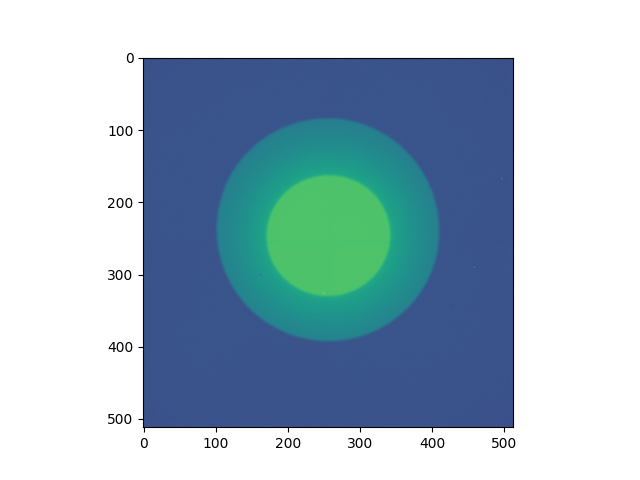

In [12]:
plt.figure()
plt.imshow(np.log1p(res['intensity']))

In [ ]:
np.dtype("<uint32")

In [ ]:
np.dtype('uint32').newbyteorder('<')